# Assignment 1

By Christian Kento Rasmussen (s204159) and Mathias Daniel Frosz Nielsen (s201968)

Collaboration policy:

The notebook was written in deepnote.com which is a service that hosts jupyter notebooks. This allows us to work collaborative in real time, so all of the code is written together by both of us.

Github link: https://github.com/christian-kento-rasmussen/02467-Computational-Social-Science-projects

## Part 1: Using web-scraping to gather data

In [2]:
from bs4 import BeautifulSoup ##A package to work with HTML data
import numpy as np
import requests #A package to make HTTP requests
import re
import pandas as pd
import matplotlib.pyplot as plt

### 1.1 Inspect the HTML of the pages above and use web-scraping to get the set of participants in 2019. Share your code and add comments to guide us through it.

In [ ]:
# ----- ORAL PRESENTATION -----
LINK = "https://2019.ic2s2.org/oral-presentations/"
r = requests.get(LINK)

soup = BeautifulSoup(r.content)


content_main_body = soup.find("div",{"class":"col-md-8 page-content-wrap"})
content_paragraphs = content_main_body.findChildren("p")[2:]
content_presentations_combined = []
content_presentations = []

## Find end of <em>
for c in content_paragraphs:
    try:
        idx = str(c).index("</em>")
        content_presentations_combined.append(str(c)[idx+9:])
    except:
        print("no </em> found")

## Add <br>s to list
for c in content_presentations_combined:
    try:
        content_presentations.append(re.split("<br>|<br/>",c))
    except:
        pass

## Remove first part of the <br> that doesn't contain the name
content_presentations = [x[16:] for c in content_presentations for x in c]

## Remove the dots that aren't abbreviations of names
content_presentations_authors_combined = []
for c in content_presentations:
    t = 0
    try:
        for idx in re.finditer("\.", c):
            idx = idx.start()
            if c[idx-2] != " " and t!=1:
                content_presentations_authors_combined.append(c[:idx])
                t+=1
    except:
        pass

content_presentations_authors = []

## Split names by commas
for c in content_presentations_authors_combined:
    content_presentations_authors.append(c.split(","))

## Squeeze dims
content_presentations_authors = [x for c in content_presentations_authors for x in c]
content_presentations_authors = np.array(content_presentations_authors)
content_presentations_authors = np.unique(content_presentations_authors)
listidx = []

## Remove whitespaces
for i, c in enumerate(content_presentations_authors):
    if c[0] == " ":
        content_presentations_authors[i] = c[1:]

# cleans up data and removes dublicate authors
content_presentations_authors = np.array(list(filter(lambda x: 'presentation' not in x, content_presentations_authors)))
content_presentations_authors[0] = content_presentations_authors[0][28:]
content_presentations_authors = np.unique(content_presentations_authors)

oralauthors = content_presentations_authors
lenoral = len(oralauthors)


# ----- POSTER PRESENTATION -----
LINK = "https://2019.ic2s2.org/posters/"
r = requests.get(LINK)
soup = BeautifulSoup(r.content)

def goodIndex(x, y):
    """
        Returns the index of y in x.
        Returns None if y does not exist in x
    """
    try:
        return x.index(y)
    except:
        return None


content_main_body = soup.find("div",{"class":"col-md-8 page-content-wrap"})
content_lists = content_main_body.findChildren("li")

content_lists = [str(c) for c in content_lists]

# cleans up each list tag to only contain strings with all names for each presenation
content_lists = [c[4:goodIndex(c, "<span>")] for c in content_lists if c[4:12]!="<strong>"]
content_lists = [c[:-5] if c[-5] == "<" else c for c in content_lists]
content_lists = [c[0:goodIndex(c, "<br/>")] for c in content_lists]

# splits each author
content_poster_authors = [re.split(", | and ", c) for c in content_lists]
content_poster_authors = [x for c in content_poster_authors for x in c]
content_poster_authors = np.unique(content_poster_authors)
posterauthors = content_poster_authors
lenposters = len(content_poster_authors)


# ----- FINAL CLEAN UP -----
# We combine the poster authors and oral authors into a single array.
# Where we then remove all duplicates
authors = np.concatenate((posterauthors, content_presentations_authors))
authors = np.unique(authors)

no </em> found


### 1.2 How many unique researchers you got in 2019?.

Using this technique we get 

In [ ]:
lenall = len(authors)
print(lenall)

887


887 unique researchers (for all years combined). 

### 1.3 Explain one or two decisions you took during the web-scraping exercise, for 2019 or any other year. Why did you take this choice? How might your decision impact the final number of authors?.

When cleaning the dataset for duplicate names we needed to decide how to handle duplicate occurrences of authors. If a name occurred twice, it might be because the person had two presentations, but it might also have been two different persons with the same name. When removing duplicates, we accept that we might throw away potential CompSci authors. 

Some of the names were also abbreviated while others were not. Therefore, a "Thomas Arnold Jensen" abbreviated to "Thomas A. Jensen" will occur twice in the dataset. Therefore, the dataset might contain duplicate authors who use several aliases. Some of this is cleaned up later when we remove all authors with duplicate who have the same author IDs, where every alias of the person should be correctly removed as all their aliases will share their author ID.  

## Part 2: Getting data from the Semantic Scholar API?.

### 2.1 Share the number of authors you will use as starting point in this exercises. Add a comment clarifying how many IC2S2 editions you included and if the collaborators were included or not.

We used all the authors from the IC2S2 2019, 2020 and 2021 editions, and found the people they collaborated with and added them as well.

In [ ]:
researchersdf = pd.read_csv('data_science_researchers.csv')
print(len(researchersdf))

131072


We ended up with 131,072 unique authors.

### 2.2 Share the code you have used to solve the exercise above.

In [ ]:
import requests
import pandas as pd
import numpy as np
import time
import os
from tqdm import tqdm


authordf = pd.DataFrame(columns = ['authorId', 'name', 'aliases', 'citationCount', 'field'])
paperdf = pd.DataFrame(columns = ['paperId', 'title', 'year', 'externalId.DOI', 'citationCount', 'fields', 'authorIds'])
paperabstractdf = pd.DataFrame(columns = ['paperId', 'abstract'])

authordf.to_csv('authordf.csv',index=False)
paperdf.to_csv('paperdf.csv',index=False)
paperabstractdf.to_csv('paperabstractdf.csv',index=False)


# data frames
df_ds = pd.read_csv('data_science_researchers.csv')
authorIds = df_ds['authorId']

authordf = pd.DataFrame(columns=['authorId', 'name', 'aliases', 'citationCount', 'field'])
paperdf = pd.DataFrame(columns=['paperId', 'title', 'year', 'externalId.DOI', 'citationCount', 'fields', 'authorIds'])
paperabstractdf = pd.DataFrame(columns=['paperId', 'abstract'])


def recursion_is_cool(authorIds):
    ## Stuff we want to store
    # authordf:
    aauthorId = []
    aname = []
    aaliases = []
    acitationCount = []
    afield = []

    # paperdf
    ppaperId = []
    ptitle = []
    pyear = []
    pexternalIdDOI = []
    pcitationCount = []
    pfields = []
    pauthorIds = []

    # paperabstractdf
    papaperId = []
    paabstract = []
    ##

    BASE_URL = "https://api.semanticscholar.org/graph/"
    VERSION = "v1/"
    RESOURCE = "author/batch"
    FIELDS = '?fields=authorId,name,aliases,citationCount,papers,papers.title,papers.year,papers.externalIds,papers.s2FieldsOfStudy,papers.citationCount,papers.authors,papers.abstract'
    my_url = BASE_URL + VERSION + RESOURCE + FIELDS

    params = {'ids': authorIds}
    header = {'x-api-key': 'G86x6pLSg51K6g4XaR0PF5I44qYW22k22Ph7ZXHR'}

    request = requests.post(my_url, json=params, headers=header)
    request = request.json()

    if 'message' in request and request['message'] == "Too Many Requests":
        # print(request)
        print("too many requests")
        # breaks if receiving "Too Many Requests"
        return aauthorId, aname, aaliases, acitationCount, afield, ppaperId, ptitle, pyear, pexternalIdDOI, pcitationCount, pfields, pauthorIds, papaperId, paabstract

    # Divide and conquer if there's an error for an author
    # Didn't work, save failed IDs in call of function
    if 'message' in request and request['message'] == "Internal server error":
        return None, None, None, None, None, None, None, None, None, None, None, None, None, None
    try:
        for req in request:
            unique, pos = np.unique(
                [category['category'] for paper in req['papers'][:] for category in paper['s2FieldsOfStudy']],
                return_inverse=True)
            aauthorId.append(req['authorId'])
            aname.append(req['name'])
            aaliases.append(req['aliases'])
            acitationCount.append(req['citationCount'])
            afield.append('' if len(unique) == 0 else unique[np.bincount(pos).argmax()])
            for paper in req['papers']:
                ppaperId.append(paper['paperId'])
                ptitle.append(paper['title'])
                pyear.append(paper['year'])
                pexternalIdDOI.append(paper['externalIds'].get('DOI'))
                pcitationCount.append(paper['citationCount'])
                pfields.append('' if paper['s2FieldsOfStudy'] == [] else paper['s2FieldsOfStudy'][0]['category'])
                pauthorIds.append(paper['authors'][0]['authorId'])
                papaperId.append(paper['paperId'])
                paabstract.append(paper['abstract'])

        return aauthorId, aname, aaliases, acitationCount, afield, ppaperId, ptitle, pyear, pexternalIdDOI, pcitationCount, pfields, pauthorIds, papaperId, paabstract
    except:
        return None, None, None, None, None, None, None, None, None, None, None, None, None, None


batch_size = 50
failed_ids = []
for i in tqdm(range(0, len(authorIds), batch_size)):
    # API limit of 100 request a second
    if i % 75 == 0:
        time.sleep(.5)

    authorIds_in_batch = list((authorIds[i:i + batch_size].astype("int64")).astype(str))


    gaauthorId, ganame, gaaliases, gacitationCount, gafield, gppaperId, gptitle, gpyear, gpexternalIdDOI, gpcitationCount, gpfields, gpauthorIds, gpapaperId, gpaabstract = recursion_is_cool(
        authorIds_in_batch)
    if gaauthorId == None:
        failed_ids.extend(authorIds_in_batch)
        continue

    authordfdict = {
        'authorId': gaauthorId,
        'name': ganame,
        'aliases': gaaliases,
        'citationCount': gacitationCount,
        'field': gafield
    }
    authordf = pd.DataFrame(authordfdict)
    paperdfdict = {
        'paperId': gppaperId,
        'title': gptitle,
        'year': gpyear,
        'externalId.DOI': gpexternalIdDOI,
        'citationCount': gpcitationCount,
        'fields': gpfields,
        'authorIds': gpauthorIds
    }
    paperdf = pd.DataFrame(paperdfdict)
    paperabstractdfdict = {
        'paperId': gpapaperId,
        'abstract': gpaabstract
    }
    paperabstractdf = pd.DataFrame(paperabstractdfdict)

    authordf.to_csv("authordf.csv", header=False, index=False, mode='a')
    paperdf.to_csv("paperdf.csv", header=False, index=False, mode='a')
    paperabstractdf.to_csv("paperabstractdf.csv", header=False, index=False, mode='a')


with open('failed_ids.txt', 'w') as f:
    f.write(str(failed_ids))

We chose to ignore the batches of authors that returned 'Internal Server Error' because of the immense time investment it ended up taking troubleshooting this. Ideally, one would use a divide and conquer method for the batches that could not be handled, but our attempt at this ended up having a lot of issues. We could also have processed the batches of authors that failed separately with a smaller batch size, which was the idea behind saving the failed author IDs, but this would also cost a lot of time. 

### 2.3 How long is your final Author dataframe? How long is your final Paper dataframe?

In [3]:
authordf = pd.read_csv('authordf-20230226-161241.csv')
paperdf = pd.read_csv('paperdf-20230226-161733.csv')
print("Lenght of authordf dataset: ",len(authordf))
print("Lenght of paperdf dataset: ",len(paperdf))

paperdf = paperdf.drop_duplicates(subset='paperId', keep="last")
print("Lenght of paperdf dataset without duplicate papers: ",len(paperdf))

Lenght of authordf dataset:  98300
Lenght of paperdf dataset:  6065618
Lenght of paperdf dataset without duplicate papers:  4868365


We ended up processing 98,300 out of the 131,072 authors used, and from these authors we found 6,065,618 papers. When removing all papers with the same ID we got 4,868,365 papers.

## Part 3: Law of large numbers?.

### 3.1 Compare the evolution of the cumulative average for the Gaussian, Pareto and LogNormal distribution?. What do you observe? Would you expect these results?. Why?.

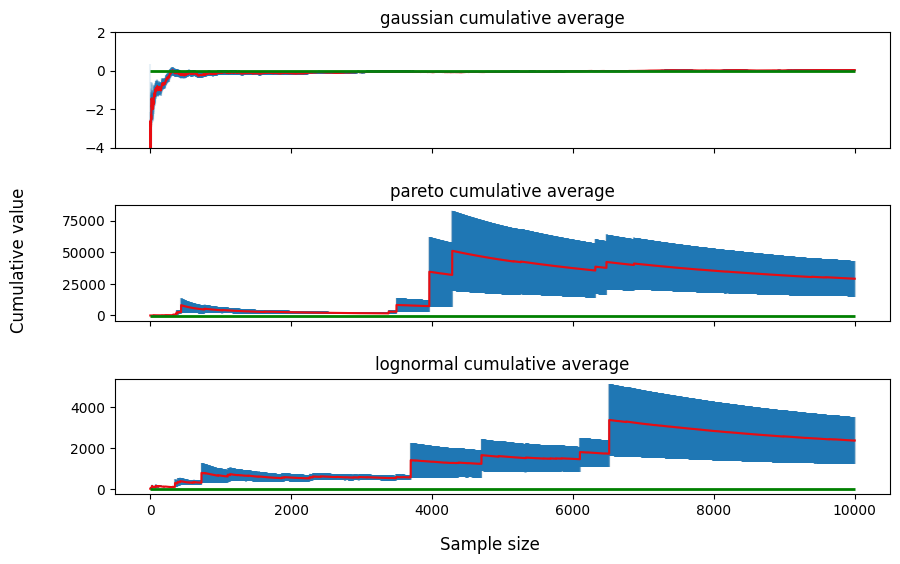

In [28]:
np.random.seed(69420)
N=10000

# Sampling data points
gaussian_dist = np.random.normal(loc=0, scale=4,size=N)
a, m = .5, 1. 
pareto_dist = (np.random.pareto(a, N) + 1) * m
lognormal_dist = np.random.lognormal(0, 4, N)

# Calculates cumulative values
gaussian_cum_average = [np.mean(gaussian_dist[:i]) for i in range(1,N)]
gaussian_cum_std = [np.std(gaussian_dist[:i])/np.sqrt(i) for i in range(1,N)]

pareto_cum_average = [np.mean(pareto_dist[:i]) for i in range(1,N)]
pareto_cum_std = [np.std(pareto_dist[:i])/np.sqrt(i) for i in range(1,N)]

lognormal_cum_average = [np.mean(lognormal_dist[:i]) for i in range(1,N)]
lognormal_cum_std = [np.std(lognormal_dist[:i])/np.sqrt(i) for i in range(1,N)]

# Creates plots
figure, axis = plt.subplots(3, 1, sharex=True,figsize=(10,6))
figure.subplots_adjust(hspace=.5)

axis[0].set_ylim([-4,2])
axis[0].errorbar(range(1,N), gaussian_cum_average, yerr=gaussian_cum_std,label='gaussian cumulative average',alpha=.1)
axis[0].plot(range(1,N), gaussian_cum_average,label='gaussian cumulative average',color='r')
axis[0].hlines(y=0,xmin=0, xmax=N,linewidth=2, color='g')
axis[0].set_title('gaussian cumulative average')


axis[1].errorbar(range(1,N), pareto_cum_average, yerr=pareto_cum_std,label='pareto cumulative average',alpha=.1)#
axis[1].plot(range(1,N), pareto_cum_average,label='pareto cumulative average',color='r')
axis[1].hlines(y=(a * m)/(a-1),xmin=0, xmax=N,linewidth=2, color='g')
axis[1].set_title('pareto cumulative average')

axis[2].errorbar(range(1,N), lognormal_cum_average, yerr=lognormal_cum_std,label='lognormal cumulative average',alpha=.1)
axis[2].plot(range(1,N), lognormal_cum_average,label='lognormal cumulative average',color='r')
axis[2].hlines(y=np.exp(0+4/2),xmin=0, xmax=N,linewidth=2, color='g')
axis[2].set_title('lognormal cumulative average')

figure.supylabel('Cumulative value')
figure.supxlabel('Sample size')

# shows plot
plt.show()

The red lines are the sample means, the blue bars are the standard errors of the means, the green lines are the population mean.

We see that the population mean fits the sample mean for the Gaussian distribution, but for the Pareto and Lognormal distributions, the population mean quickly grows large compared to the population mean. This was at first not expected, but considering the heavy tails of the Pareto and Lognormal distributions, the results make a lot of sense.

### 3.2 Compare the cumulative median vs the cumulative average for the three distributions. What do you observe? Can you draw any conclusions regarding which statistics (the mean or the median) is more usfeul in the different cases?

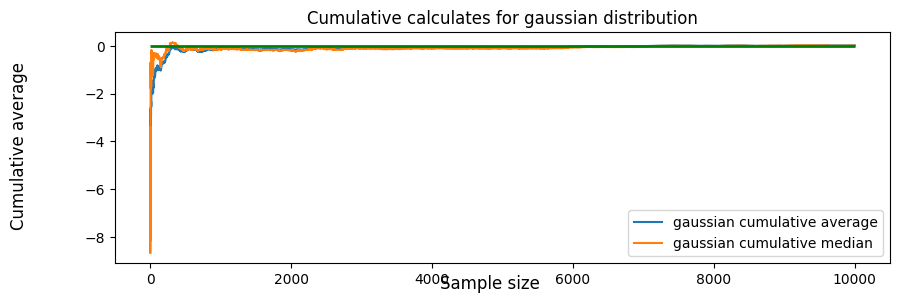

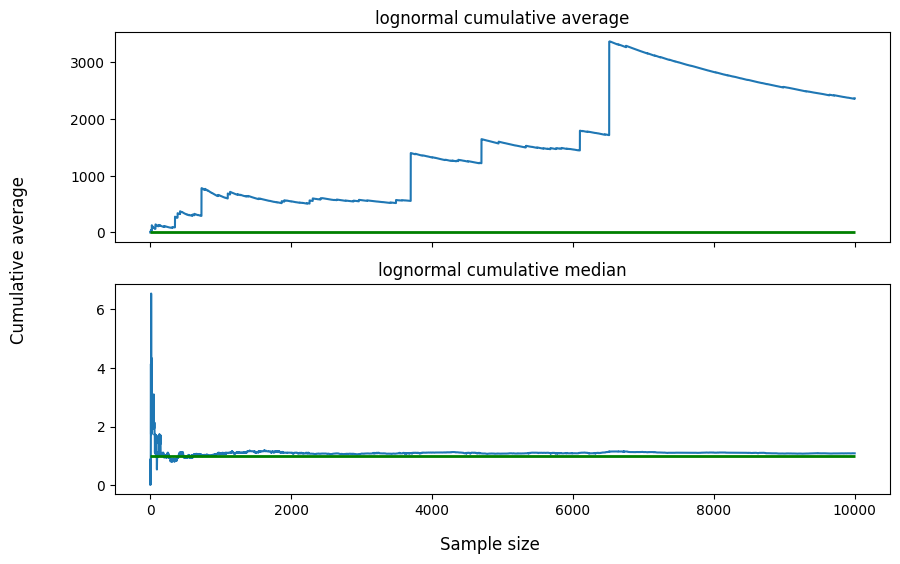

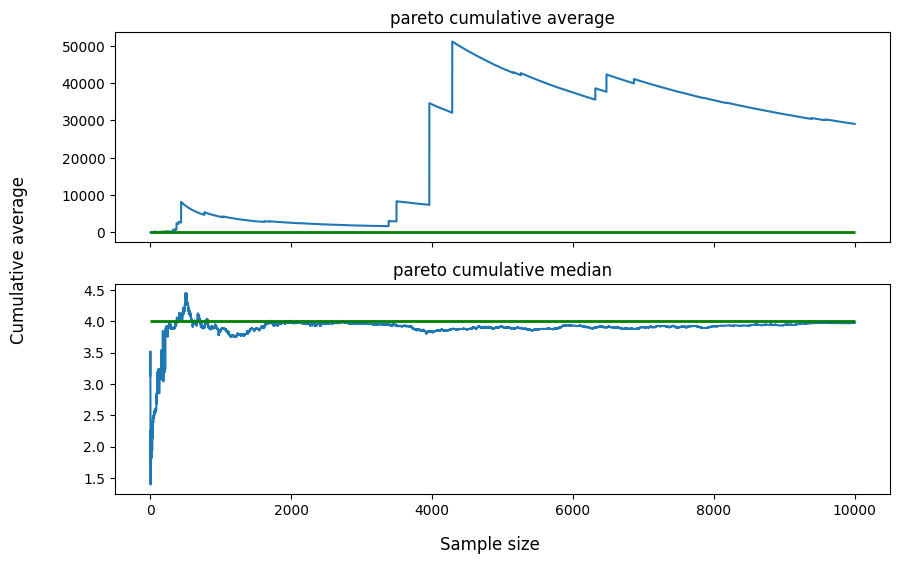

In [22]:
# Calculates cumulative data
gaussian_cum_average = [np.mean(gaussian_dist[:i]) for i in range(1,N)]
gaussian_cum_median = [np.median(gaussian_dist[:i]) for i in range(1,N)]
gaussian_cum_std = [np.std(gaussian_dist[:i])/np.sqrt(i) for i in range(1,N)]

pareto_cum_average = [np.mean(pareto_dist[:i]) for i in range(1,N)]
pareto_cum_median = [np.median(pareto_dist[:i]) for i in range(1,N)]
pareto_cum_std = [np.std(pareto_dist[:i])/np.sqrt(i) for i in range(1,N)]

lognormal_cum_average = [np.mean(lognormal_dist[:i]) for i in range(1,N)]
lognormal_cum_median = [np.median(lognormal_dist[:i]) for i in range(1,N)]
lognormal_cum_std = [np.std(lognormal_dist[:i])/np.sqrt(i) for i in range(1,N)]


# Creates plots for gaussian distribution
figure, axis = plt.subplots(figsize=(10,3))
axis.plot(range(1,N), gaussian_cum_average,label='gaussian cumulative average')
axis.plot(range(1,N), gaussian_cum_median,label='gaussian cumulative median')
axis.hlines(y=0,xmin=0, xmax=N,linewidth=2, color='g')
axis.legend()
axis.set_title('Cumulative calculates for gaussian distribution')
figure.supylabel('Cumulative average')
figure.supxlabel('Sample size')
plt.show()

# Creates plots for lognormal distribution
figure, axis = plt.subplots(2, 1, sharex=True,figsize=(10,6))
axis[0].plot(range(1,N), lognormal_cum_average,label='lognormal cumulative average')
axis[0].hlines(y=np.exp(2),xmin=0, xmax=N,linewidth=2, color='g')
axis[0].set_title('lognormal cumulative average')
axis[1].plot(range(1,N), lognormal_cum_median,label='lognormal cumulative median')
axis[1].hlines(y=np.exp(0),xmin=0, xmax=N,linewidth=2, color='g')
axis[1].set_title('lognormal cumulative median')
figure.supylabel('Cumulative average')
figure.supxlabel('Sample size')
plt.show()

# Creates plots for pareto distribution
figure, axis = plt.subplots(2, 1, sharex=True,figsize=(10,6))
axis[0].plot(range(1,N), pareto_cum_average,label='pareto cumulative average')
axis[0].hlines(y=(a * m)/(a-1),xmin=0, xmax=N,linewidth=2, color='g')
axis[0].set_title('pareto cumulative average')
axis[1].plot(range(1,N), pareto_cum_median,label='pareto cumulative median')
axis[1].set_title('pareto cumulative median')
axis[1].hlines(y=2**2,xmin=0, xmax=N,linewidth=2, color='g')
figure.supylabel('Cumulative average')
figure.supxlabel('Sample size')
plt.show()

The blue lines are the median or average value, the green lines are the population mean.

The Pareto and Lognormal distributions are both heavy-tailed distributions, and therefore the expectation of the sample is not always finite, which is a condition to the Law of Large Numbers. We see that these distributions have sudden spikes in their cumulative average, but not their cumulative median, due to the majority of the samples still being in the same range - a single outlier doesn't affect the median, but can heavily affect the mean. 

Therefore, it is more useful to use the median as a statistic in the case of heavy-tailed distributions such as the Pareto and Lognormal distributions.

### 3.3 Consider the plots you made using the citation count data in point 14. What do you observe? What are the implications?

Number of citations in 2009: 	 169533
paperdf2009 citations mean: 	 43.51043159738812 
paperdf2009 citations median: 	 7.0


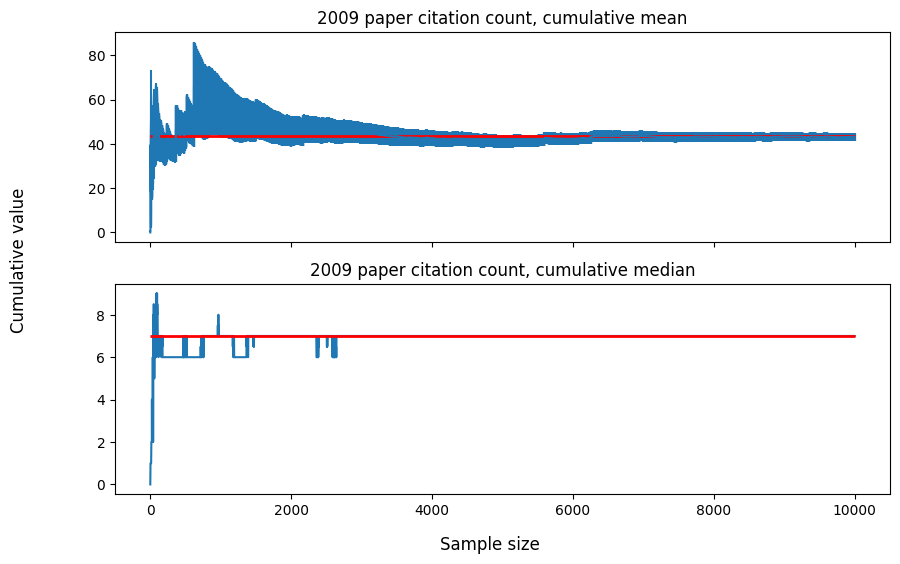

In [29]:
np.random.seed(42069)

# gets citations
paperdf2009 = paperdf[paperdf['year'] == 2009]
paperdf2009_citations = paperdf2009['citationCount']
print(f"Number of citations in 2009: \t {len(paperdf2009_citations)}")

# gets basic statistics
paperdf2009_citations_mean = np.mean(paperdf2009_citations)
paperdf2009_citations_median = np.median(paperdf2009_citations)
print(f'paperdf2009 citations mean: \t {paperdf2009_citations_mean} \npaperdf2009 citations median: \t {paperdf2009_citations_median}' )

# generates sample
sample_citations_09 = np.random.choice(paperdf2009_citations,10000)

# calculates cumulative statistics
sample_citations_09_cum_average = [np.mean(sample_citations_09[:i]) for i in range(1,N)]
sample_citations_09_cum_median = [np.median(sample_citations_09[:i]) for i in range(1,N)]
sample_citations_09_cum_std = [np.std(sample_citations_09[:i])/np.sqrt(i) for i in range(1,N)]

# Creates plots for  distribution
figure, axis = plt.subplots(2, 1, sharex=True,figsize=(10,6))
axis[0].errorbar(range(1,N), sample_citations_09_cum_average, yerr=sample_citations_09_cum_std,label='2009 paper citation count, cumulative mean')
axis[0].hlines(y=paperdf2009_citations_mean,xmin=0, xmax=N,linewidth=2, color='r')
axis[0].set_title('2009 paper citation count, cumulative mean')
axis[1].plot(range(1,N), sample_citations_09_cum_median,label='2009 paper citation count, cumulative medi')
axis[1].hlines(y=paperdf2009_citations_median,xmin=0, xmax=N,linewidth=2, color='r')
axis[1].set_title('2009 paper citation count, cumulative median')
figure.supylabel('Cumulative value')
figure.supxlabel('Sample size')
plt.show()


The paper citation samples doesn't seem to be drawn from as heavy-tailed a distribution as the ones used in the previous question, as can be seen from the graph of the cumulative mean, where the sample mean closely approximates the population mean after a few thousand samples. However, as the mean is ~44 and the median is 7, the underlying distribution is either skewed or heavy-tailed. This means that it is important, to look at both numbers when analysing the data. Because just looking at the mean would lead to a faulty conclusion that most papers have about 44 citations when they in reality only have 7.

In [32]:
paperdf2009_citations_mean = np.mean(paperdf2009_citations)
paperdf2009_citations_median = np.median(paperdf2009_citations)
paperdf2009_citations_sd = np.std(paperdf2009_citations)
npskew = (paperdf2009_citations_mean-paperdf2009_citations_median)/paperdf2009_citations_sd
print(npskew)


0.15163693930212546


### What do you think are the main take-home message of this exercise?

Using the sample mean can be misleading when dealing with heavy-tailed distributions. Therefore, it is important to examine the distribution of the sample data you've gathered when describing it using sample statistics.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2916efa0-c445-43ca-8dcd-0a1bcdbbd016' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>